In [1]:
!pip install hdbscan -q
!pip install pymatgen -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
sys.path.append('../autoencoder')


from fastai import *
from fastai.vision.all import *

from src.band_plotters import *
from src.TensorImageNoised import *
from src.transforms import Binarize

sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
from model import *

In [3]:
DATA_DIRECTORY = Path("/storage/materials_project/images")

# Select Fingerprint Name and Length Here:

In [4]:
FINGERPRINT_LENGTH = 98
FINGERPRINT_NAME = "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH)

# WIDTH=224
PERPLEXITY = 30
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

224_2channel_resnet_L=98


To make a new fingerprint all you need to change is the constants above and/or the calc_fingerprint function below.

# Start with Anupam's list of materials

In [5]:
df_material = pd.read_csv("../fingerprints/materials_project/df_full_structure.csv", index_col="material_id")
df_material.head()

,flat,flat_segments,formula,synth_score,Cluster_ID,cluster_size,sublattice_element,dbcv_cluster,probabilities,paper_titles,experimentally_observed,band_gap,synth_score_2,sub_lattice_structure,lattice_structure
material_id,,,,,,,,,,,,,,,
mp-7,True,[4],S,0.013924,-1,24875,S,0.846820,0.000000,"['The lattice of rhombohedral sulfur', 'The crystal and molecular structure of S6 (Sulfur-6)', 'The crystal and molecular structure of S6 (sulfur-6)', 'Redetermination of the crystal and molecular structure of cyclohexasulphur, S6']",True,2.2079,0.999939,"{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[5.83749204, 0.06254491, -2.71890814], [-4.28350897, 3.9662647, -2.71900595], [0.02407769, 0.0625842, 6.43958097]], 'pbc': (True, True, True), 'a': 6.439929087854037, 'b': 6.439929978087647, 'c': 6.43993009173481, 'alpha': 114.75185786877043, 'beta': 114.75184782858017, 'gamma': 114.75183455160276, 'volume': 152.79889506945906}, 'properties': {}, 'sites': [{'species': [{'element': 'S', 'occu': 1}], 'abc': [0.24492283, 0.14077002, 0.90933939], 'xyz': [0.848640219099403, 0.6305601157552272, 4.80...","{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[5.83749204, 0.06254491, -2.71890814], [-4.28350897, 3.9662647, -2.71900595], [0.02407769, 0.0625842, 6.43958097]], 'pbc': (True, True, True), 'a': 6.439929087854037, 'b': 6.439929978087647, 'c': 6.43993009173481, 'alpha': 114.75185786877043, 'beta': 114.75184782858017, 'gamma': 114.75183455160276, 'volume': 152.79889506945906}, 'properties': {}, 'sites': [{'species': [{'element': 'S', 'occu': 1}], 'abc': [0.24492283, 0.14077002, 0.90933939], 'xyz': [0.848640219099403, 0.6305601157552272, 4.80..."
mp-25,True,[3],N2,0.127548,63,282,N,0.212178,0.104165,"['Electron Diffraction and the Structure of alpha-N2', 'Error estimates for solid-state density-functional theory predictions: an overview by means of the ground-state elemental crystals', 'A refinement of the positional parameter in alpha-nitrogen', 'A re-examination of the crystal structures of alpha and beta nitrogen']",True,7.3685,0.893845,"{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[5.56051766, -0.0, -0.0], [0.0, 5.56051766, 0.0], [0.0, 0.0, 5.56051766]], 'pbc': (True, True, True), 'a': 5.56051766, 'b': 5.56051766, 'c': 5.56051766, 'alpha': 90.0, 'beta': 90.0, 'gamma': 90.0, 'volume': 171.92762867243763}, 'properties': {}, 'sites': [{'species': [{'element': 'N', 'occu': 1}], 'abc': [0.05739733, 0.05739733, 0.05739733], 'xyz': [0.3191588671018478, 0.3191588671018478, 0.3191588671018478], 'properties': {'magmom': 0.0}, 'label': 'N'}, {'species': [{'element': 'N', 'occu': 1...","{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[5.56051766, -0.0, -0.0], [0.0, 5.56051766, 0.0], [0.0, 0.0, 5.56051766]], 'pbc': (True, True, True), 'a': 5.56051766, 'b': 5.56051766, 'c': 5.56051766, 'alpha': 90.0, 'beta': 90.0, 'gamma': 90.0, 'volume': 171.92762867243763}, 'properties': {}, 'sites': [{'species': [{'element': 'N', 'occu': 1}], 'abc': [0.05739733, 0.05739733, 0.05739733], 'xyz': [0.3191588671018478, 0.3191588671018478, 0.3191588671018478], 'properties': {'magmom': 0.0}, 'label': 'N'}, {'species': [{'element': 'N', 'occu': 1..."
mp-35,True,"[1, 2, 3, 4]",Mn,0.007099,-1,24875,Mn,0.846820,0.000000,"['Crystal structure of alpha-manganese', 'Antiferromagnetic structure of alpha-manganese and a magnetic structure of beta-manganese', 'Magnetic structure of alpha-Mn', 'A refiment of the parameters of alpha manganese', 'Solid phases of the Mn-C system', 'Error estimates for solid-state density-functional theory predictions: an overview by means of the ground-state elemental crystals', 'Preparation of alpha-manganese single crystals and their physical properties', 'Magnetic and crystallographic order in alpha-manganese', 'A refinement of the atomic and thermal parameter

# Fingerprint Functions Here
Fingerprint functions take material ID as only input

## Resnet AE

In [6]:
def run_resnet_one_mat(material_id, CNN_model, input_band_image_type, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"{material_id}.png"
        
        # Use the dataloaders to preprocess the input image
        dl = CNN_model.dls.test_dl([image_filename])
        # Forward pass through the encoder
        with torch.no_grad():
            encoded_representation = CNN_model.model.encoder(dl.one_batch()[0])
        #out = trained_model.encoder(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-4.png")

        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return encoded_representation.flatten().detach().numpy()

# resnet_input_file_type = "grayscale_4ev_linewidth3"
# change path to the location of the desired trained model
model_name = "resnet18"
model_path = f"../autoencoder/models/mp_models/{model_name}.pkl"
resnet_model = load_learner(model_path)

fingerprint = run_resnet_one_mat("mp-88", resnet_model, "")
print(fingerprint)
print(len(fingerprint))

[0.19057909 0.0871634  2.9363995  2.9847589  3.5717373  3.5603118
 2.9724271  0.10542203 0.23998821 5.195095   4.2632217  4.3253784
 4.9800844  2.2932851  0.10291772 0.21524562 3.6416123  3.6008482
 4.0520525  5.783118   3.064374   0.05787613 0.15349604 1.6496515
 4.633303   4.105718   5.030265   3.113788   0.05355439 0.34076115
 2.2509816  5.770562   3.7597454  3.5395327  2.7153192  0.03148469
 0.22108981 1.8660498  3.8944025  3.0306997  4.3384824  1.4494731
 0.14381202 0.31159383 3.1707666  2.396067   3.3490524  3.4311388
 1.2637639  0.23619448 4.0588193  0.8432996  2.804359   3.197901
 3.0828297  0.4685945  0.11600085 6.8483624  0.         3.8048346
 2.5130029  4.211054   0.47143137 0.1020326  7.016394   0.6679641
 3.6065588  3.8384995  3.5807028  0.5194986  0.0904058  4.189587
 0.6612454  1.9524806  3.6530461  4.3780017  0.48149702 0.12242276
 3.405908   0.65702826 3.008779   2.5559523  3.755053   0.44755787
 0.14760174 3.820825   0.14653997 2.4601145  2.8222945  3.02344
 0.5708799

## View All Fingerprint Functions

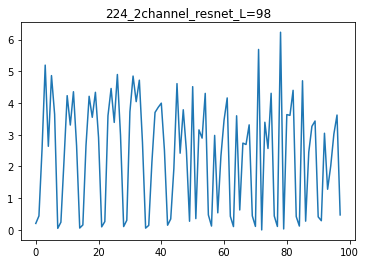

In [7]:
fingerprint_functions = {
    "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH): lambda x: run_resnet_one_mat(x, resnet_model, "", data_directory=DATA_DIRECTORY),    
}


for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("mp-8")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

In [8]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [ ]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 33251


In [ ]:
#check for NaNs 
np.isnan(fingerprint_array).sum()
print(len(fingerprint_array))

# Create T-SNE Reduced Dimension Fingerprints

In [ ]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=100.0, init="pca",learning_rate=100, random_state=0, perplexity=PERPLEXITY ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

# Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [ ]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=4, min_samples=2, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

In [ ]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.title("fingerprint_length={0}".format(FINGERPRINT_LENGTH))

# Add fingerprints, T-SNE to dataframe

In [ ]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df["labels"] = labels
df.head()

In [ ]:
df.to_csv(f"../fingerprints/materials_project/df_{model_name}.csv")